Before continue ensure that the Libraries Importation cell runs without any errors. If so continue to run the rest of the file, otherwise assure all dependencies are properly installed. To do so, run in a terminal the following commands:
```
pip3 install matplotlib
pip3 install pandas
pip3 install openpyxl
```

In [41]:
import matplotlib.pyplot as plt
from datetime import datetime
from math import log, exp
from pprint import pprint
import pandas as pd
import numpy as np
import scipy
import os

In [57]:
def database_compiler (start_year, end_year, export=False):
    dataframe = pd.DataFrame()
    for year in range(start_year, end_year, 5):
        filedata = pd.read_excel("RQAS TIET04200 - {}-{}.xlsx".format(year, year + 5))
        dataframe = dataframe.append(filedata, ignore_index=True)
    if export:
        dataframe.to_excel("RQAS TIET04200 - 1976-2021.xlsx", index=False)
    else:
        return dataframe

In [87]:
# Checks if the concatenated file exists, otherwise load each individual file and concatenate them:
if not os.path.exists("RQAS TIET04200 - 1976-2021.xlsx"):
    database_compiler(1976,2021, export=True)

dateparse = lambda dates: [datetime.strptime(date, "%d/%m/%Y") for d in dates]
# Loads the concatenated file:
df = pd.read_excel("RQAS TIET04200 - 1976-2021.xlsx")

In [88]:
# Convert strings containing dates to 'datetime' type:
df['Período DE'] = pd.to_datetime(df['Período DE'], infer_datetime_format=True)
df['Período ATE'] = pd.to_datetime(df['Período ATE'], infer_datetime_format=True)
df['Data Coleta'] = pd.to_datetime(df['Data Coleta'], infer_datetime_format=True)
# Replace commas with periods to be able to convert 'string' to 'float' (on numeric values):
df['Valor']=df['Valor'].replace(',','.',regex=True)

In [89]:
# Creates a df copy for a given parameter to avoid the case where changing the original df also changes these:
def df_by_parameter(parameter):
    df_slice = df.loc[df['Parametro'] == parameter , ['Data Coleta', 'Valor']].copy()
    df_slice['Valor'] = pd.to_numeric(df_slice['Valor'])
    return df_slice
# Creates a df copy for each relevant parameter:
df_pH = df_by_parameter('pH')
df_Fos = df_by_parameter('Fósforo Total')
df_DBO = df_by_parameter('DBO (5, 20)')
df_Nit = df_by_parameter('Nitrogênio Total')
df_ColFec = df_by_parameter('Coliformes Totais - TTM')
df_Turb = df_by_parameter('Turbidez')
df_Res = df_by_parameter('Sólido Total')
df_OxDis = df_by_parameter('Oxigênio Dissolvido')
# For 'DifTemp' parameter it's necessary to caclulate the values subtracting 'TempAr' from 'TempAgua':
df_TempAgua = df_by_parameter('Temperatura da Água')
df_TempAr = df_by_parameter('Temperatura do Ar')
df_DifTemp = df_TempAgua.merge(df_TempAr, how='inner', on='Data Coleta', suffixes=(" Temp Agua", " Temp Ar"))
df_DifTemp['Diferença de Temperatura'] = df_DifTemp['Valor Temp Agua'] - df_DifTemp['Valor Temp Ar']

In [105]:
df_params = [df_pH, df_Fos, df_DBO, df_Nit, df_ColFec, df_Turb, df_Res, df_OxDis, df_DifTemp]
# for df_param in df_params:
#     print(df_param.shape[0])
parameters = df['Parametro'].unique()
for parameter in parameters:
    df_param = df_by_parameter(parameter)
    print(df_param.shape[0])
#df_ColFec['Data Coleta'].describe()

305
305
301
293
303
282
270
297
302
302
221
301
244
266
305
72
304
302
262
295
243
117
288
275
292
175
251
39
180
289
286


ValueError: Unable to parse string "Marrom" at position 0

Para poder realizar as conversões
partindo das medições para cada um dos fatores de interesse
é necessário realizar uma conversão para obter os 
a qualidada de cada um dos parâmetros individualmente e, apartir dessas informações juntamente com o peso correspondente de cada um deles, calcular o IQA

O primeiro passo portanto, se resume em extr

Através da ferramenta [Plot Digitalizer](https://plotdigitizer.com/) foi possível extrair da imagem uma série de pontos distribuídos ao longo de cada curva, considerando as devidas escalas de ambos eixos para cada gráfico.
As informações foram posteriormente baixadas em arquivos .csv e, portanto 

In [4]:
# Uses list comprehension to load all reference files at once as a DataFrame:
ref_qi = [pd.read_csv("iqa-q{}-reference.csv".format(n)) for n in range(1, 10)]
# Asigns a variable to each Dataframe loaded:
ref_q1, ref_q2, ref_q3, ref_q4, ref_q5, ref_q6, ref_q7, ref_q8, ref_q9 = ref_qi

Uma vez carregadas, podemos utilizar as séries de pontos de cada um dos parâmetros e desenvolver uma função polinomial que descreva, com o máximo de precisão possível, a relação entre o valor das medições e a qualidade relativa de cada parâmetro. Para isso, 

In [51]:
def interpol_fit(data, x_label, y_label, interpolation_method='linear'):
    return scipy.interpolate.interp1d(data[x_label], data[y_label], kind=interpolation_method, fill_value='extrapolate')

f_q1, f_q2, f_q3, f_q4, f_q5, f_q6, f_q7, f_q8, f_q9 = [interpol_fit(ref_q, 'x', ' y', interpolation_method='cubic') for ref_q in ref_qi]

In [52]:
def calculate_qi(value, function, upper_limit=None, upper_response=None, lower_limit=None, lower_response=None):
    if lower_limit <= value <= upper_limit:
        return function(value)
    elif (upper_limit != None) and (value > upper_limit):
        return upper_response
    elif (lower_limit != None) and (value > lower_limit):
        return lower_response
    elif (upper_limit != upper_limit) or (lower_limit != lower_limit):
        raise ValueError("Restrains are not valid")
    else:
        raise ValueError("Value is not valid for given restrains")

In [54]:
spacing = 100
# Calculate q1 from 'ColFec':
values_ColFec = np.linspace(1, 1e5, spacing)
values_q1 = np.fromiter( (calculate_qi(ColFec, f_q1, 1e5, 3, 1, np.nan) for ColFec in values_ColFec) , float)
# Calculate q2 from 'pH':
values_pH = np.linspace(2, 12, spacing)
values_q2 = np.fromiter( (calculate_qi(pH, f_q2, 12, 3, 2, 2) for pH in values_pH) , float)
# Calculate q3 from 'DBO':
values_DBO = np.linspace(0, 30, spacing)
values_q3 = np.fromiter( (calculate_qi(DBO, f_q3, 30, 2, 0, np.nan) for DBO in values_DBO) , float)
# Calculate q4 from 'Nit':
values_Nit = np.linspace(0, 100, spacing)
values_q4 = np.fromiter( (calculate_qi(Nit, f_q4, 100, 1, 0, np.nan) for Nit in values_Nit) , float)
# Calculate q5 from 'Fos':
values_Fos = np.linspace(0, 10, spacing)
values_q5 = np.fromiter( (calculate_qi(Fos, f_q5, 10, 1, 0, np.nan) for Fos in values_Fos) , float)
# Calculate q6 from 'DifTemp':
values_DifTemp = np.linspace(-5, 15, spacing)
values_q6 = np.fromiter( (calculate_qi(DifTemp, f_q6, 12, 9, -5, np.nan) for DifTemp in values_DifTemp), float)
# Calculate q7 from 'Turb':
values_Turb = np.linspace(0, 100, spacing)
values_q7 = np.fromiter( (calculate_qi(Turb, f_q7, 100, 5, 0, np.nan) for Turb in values_Turb) , float)
# Calculate q8 from 'Res':
values_Res = np.linspace(0, 500, spacing)
values_q8 = np.fromiter( (calculate_qi(Res, f_q8, 500, 32, 0, np.nan) for Res in values_Res) , float)
# Calculate q9 from 'OxDis':
values_OxDis = np.linspace(0, 140, spacing)
values_q9 = np.fromiter( (calculate_qi(OxDis, f_q9, 140, 47, 0, np.nan) for OxDis in values_OxDis) , float)

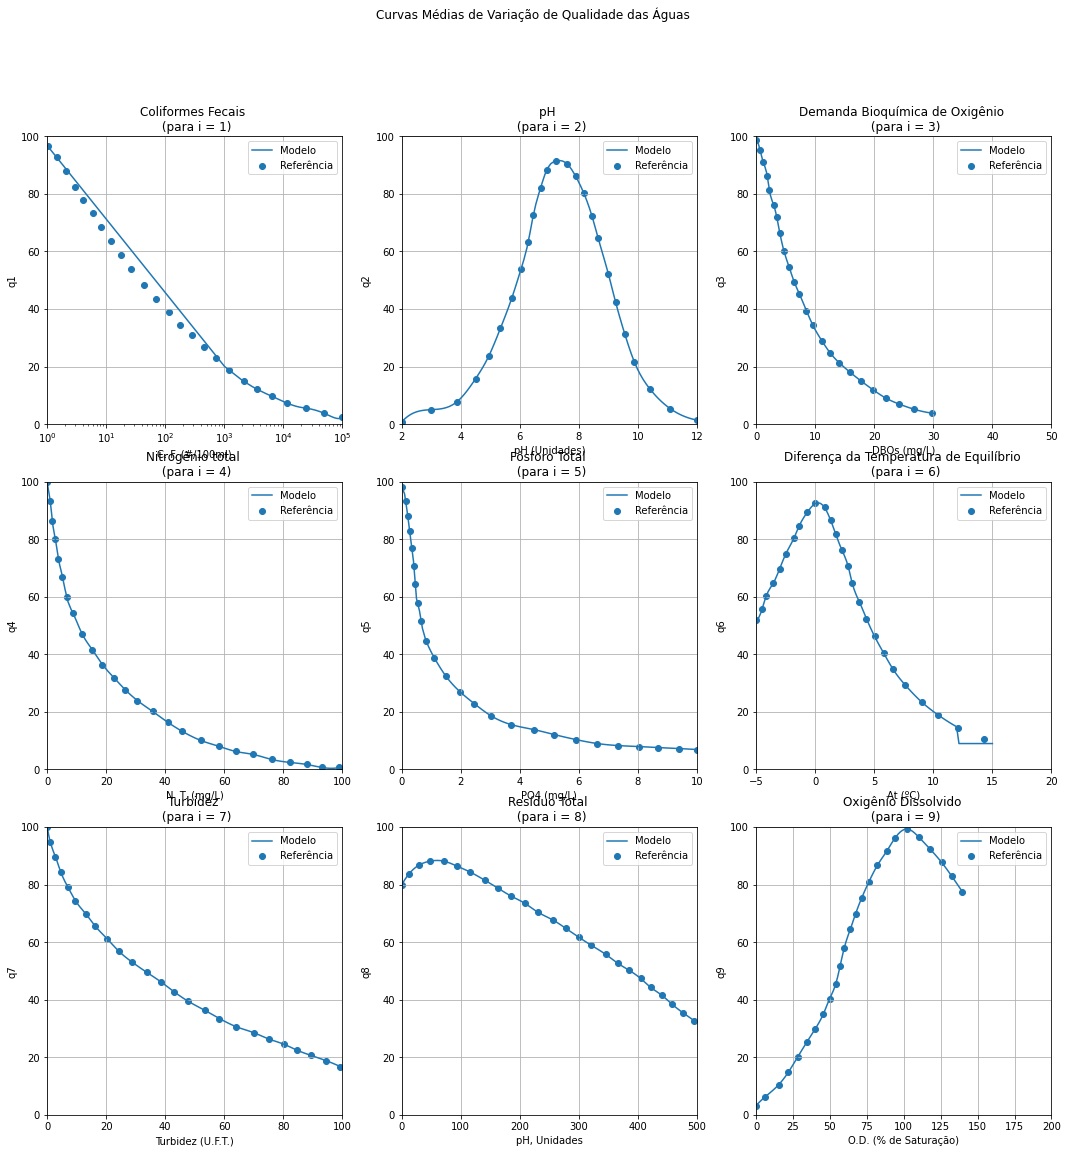

In [55]:
plt.figure(figsize=(18, 18))
plt.tight_layout()
plt.suptitle("Curvas Médias de Variação de Qualidade das Águas")

plt.subplot(3, 3, 1)
plt.title("Coliformes Fecais \n (para i = 1)")
plt.scatter(ref_q1['x'], ref_q1[' y'], label="Referência")
plt.plot(values_ColFec, values_q1, label="Modelo")
plt.xscale('log')
plt.xlabel("C. F. (#/100ml)")
plt.ylabel("q1")
plt.xlim(1, 1e5)
plt.ylim(0, 100)
plt.legend()
plt.grid()

plt.subplot(3, 3, 2)
plt.title("pH \n (para i = 2)")
plt.scatter(ref_q2['x'], ref_q2[' y'], label="Referência")
plt.plot(values_pH, values_q2, label="Modelo")
plt.xlabel("pH (Unidades)")
plt.ylabel("q2")
plt.xlim(2, 12)
plt.ylim(0, 100)
plt.legend()
plt.grid()

plt.subplot(3, 3, 3)
plt.title("Demanda Bioquímica de Oxigênio \n (para i = 3)")
plt.scatter(ref_q3['x'], ref_q3[' y'], label="Referência")
plt.plot(values_DBO, values_q3, label="Modelo")
plt.xlabel("DBOs (mg/L)")
plt.ylabel("q3")
plt.xlim(0, 50)
plt.ylim(0, 100)
plt.legend()
plt.grid()

plt.subplot(3, 3, 4)
plt.title("Nitrogênio total \n (para i = 4)")
plt.scatter(ref_q4['x'], ref_q4[' y'], label="Referência")
plt.plot(values_Nit, values_q4, label="Modelo")
plt.xlabel("N. T. (mg/L)")
plt.ylabel("q4")
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.legend()
plt.grid()

plt.subplot(3, 3, 5)
plt.title("Fósforo Total \n (para i = 5)")
plt.scatter(ref_q5['x'], ref_q5[' y'], label="Referência")
plt.plot(values_Fos, values_q5, label="Modelo")
plt.xlabel("PO4 (mg/L)")
plt.ylabel("q5")
plt.xlim(0, 10)
plt.ylim(0, 100)
plt.legend()
plt.grid()

plt.subplot(3, 3, 6)
plt.title("Diferença da Temperatura de Equilíbrio \n (para i = 6)")
plt.scatter(ref_q6['x'], ref_q6[' y'], label="Referência")
plt.plot(values_DifTemp, values_q6, label="Modelo")
plt.xlabel("At (ºC)")
plt.ylabel("q6")
plt.xlim(-5, 20)
plt.ylim(0, 100)
plt.legend()
plt.grid()

plt.subplot(3, 3, 7)
plt.title("Turbidez \n (para i = 7)")
plt.scatter(ref_q7['x'], ref_q7[' y'], label="Referência")
plt.plot(values_Turb, values_q7, label="Modelo")
plt.xlabel("Turbidez (U.F.T.)")
plt.ylabel("q7")
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.legend()
plt.grid()

plt.subplot(3, 3, 8)
plt.title("Resíduo Total \n (para i = 8)")
plt.scatter(ref_q8['x'], ref_q8[' y'], label="Referência")
plt.plot(values_Res, values_q8, label="Modelo")
plt.xlabel("pH, Unidades")
plt.ylabel("q8")
plt.xlim(0, 500)
plt.ylim(0, 100)
plt.legend()
plt.grid()

plt.subplot(3, 3, 9)
plt.title("Oxigênio Dissolvido \n (para i = 9)")
plt.scatter(ref_q9['x'], ref_q9[' y'], label="Referência")
plt.plot(values_OxDis, values_q9, label="Modelo")
plt.xlabel("O.D. (% de Saturação)")
plt.ylabel("q9")
plt.xlim(0, 200)
plt.ylim(0, 100)
plt.legend()
plt.grid()

plt.show()

In [71]:
def calculate_IQA (q_list, w_list):
    q1, q2, q3, q4, q5, q6, q7, q8, q9 = q_list
    w1, w2, w3, w4, w5, w6, w7, w8, w9 = w_list
    iqa = 1
    for q, w in zip(q_list, w_list):
        iqa *= q**w
    return iqa


Fonte: http://pnqa.ana.gov.br/indicadores-indice-aguas.aspx

In [ ]:
def classify_IQA (value, state):
    if state in ['BA', 'CE', 'ES', 'GO', 'MS', 'PB', 'PE', 'SP']:
        if  0 < value < 19: return 'Péssima'
        elif value < 36: return 'Ruim'
        elif value < 51: return 'Razoável'
        elif value < 79: return 'Boa'
        elif value < 100: return 'Ótima'
        else: raise ValueError('IQA values must be in range 0-100')
    elif state in ['AL', 'MG', 'MT', 'PR', 'RJ', 'RN', 'RS']:
        if  0 < value < 25: return 'Péssima'
        elif value < 50: return 'Ruim'
        elif value < 70: return 'Razoável'
        elif value < 90: return 'Boa'
        elif value < 100: return 'Ótima'
        else: raise ValueError('IQA values must be in range 0-100')
    else: raise ValueError('State does not use IQA classification')

In [ ]:
wi= [0.10, 0.12, 0.10, 0.10, 0.15, 0.10, 0.08, 0.17]

In [ ]:
df_iqa = pd.DataFrame()
